In [ ]:
# Handling Brainflow timestamps

# See https://openbci.com/forum/index.php?p=/discussion/3911/best-practices-for-handling-uneven-timestamps-from-brainflow-cyton


In [51]:
%reload_ext autoreload
%autoreload 2
import logging
log = lambda msg: logging.info(msg)
import os
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')


In [193]:
# input_file = "C:\\dev\\play\\brainwave-data-day\\2024-11-16-14-12-44.brainflow.csv"
# input_file = "C:\\dev\\play\\brainwave-data-day\\2024-11-15-09-10-50.brainflow.csv"
input_file = "C:\\dev\\play\\brainwave-data\\2024-11-16-21-54-46.brainflow.csv"
# input_file = "C:\\dev\\play\\brainwave-data-day\\2024-11-15-09-26-33.brainflow.csv"
# input_file = "C:\\dev\\play\\brainwave-data-day\\2024-11-16-16-12-49.brainflow.csv"
channels = ['Fpz-M1']

In [194]:
import argparse
import os

import mne
import numpy as np
import pandas as pd
from brainflow.board_shim import BoardShim, BoardIds
from brainflow.data_filter import DataFilter

from memory import garbage_collect
import pyedflib

board_id = BoardIds.CYTON_BOARD.value

log(f"Reading Brainflow file {input_file}")
restored_data = DataFilter.read_file(input_file)
log("Finished reading Brainflow file")



2024-11-17 10:32:26,991 - INFO - Reading Brainflow file C:\dev\play\brainwave-data\2024-11-16-21-54-46.brainflow.csv
2024-11-17 10:35:23,561 - INFO - Finished reading Brainflow file


In [195]:
garbage_collect(log)

restored_df = pd.DataFrame(np.transpose(restored_data))

eeg_channels = BoardShim.get_eeg_channels(board_id)

log(f"EEG channels: {eeg_channels}")

selected_columns = [restored_df.columns[0]]
num_eeg_channels_to_select = min(len(eeg_channels), len(channels))
selected_eeg_channels = [eeg_channels[i] for i in range(num_eeg_channels_to_select)]
selected_columns.extend(selected_eeg_channels)
selected_columns.append(restored_df.columns[-2])
idx_and_eeg_channels_and_timestamp = restored_df[selected_columns]

column_names = ['sampleIdx'] + channels + ['timestamp']
idx_and_eeg_channels_and_timestamp.columns = column_names
idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')

eeg_channels_only = idx_and_eeg_channels_and_timestamp[channels]


# Brainflow Cyton data in uV, MNE expects V
scaled = eeg_channels_only / 1_000_000

ch_types = ['eeg'] * len(channels)

initial_timestamp = idx_and_eeg_channels_and_timestamp['datetime'].iloc[0]
log(f"Initial timestamp: {str(initial_timestamp)} from {idx_and_eeg_channels_and_timestamp['timestamp'].iloc[0]}")



2024-11-17 10:35:50,249 - INFO - Memory Usage: 1674.45 MB GC to 2011.20 MB
2024-11-17 10:35:50,251 - INFO - EEG channels: [1, 2, 3, 4, 5, 6, 7, 8]
C:\Users\graha\AppData\Local\Temp\ipykernel_22476\4220048393.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  idx_and_eeg_channels_and_timestamp['datetime'] = pd.to_datetime(idx_and_eeg_channels_and_timestamp['timestamp'],unit="s").dt.tz_localize('UTC')
2024-11-17 10:35:52,680 - INFO - Initial timestamp: 2024-11-16 21:54:46.426238060+00:00 from 1731794086.426238


In [200]:
from datetime import timedelta


# Calculate the difference between consecutive 'sampleIdx' rows
def find_sample_index_gaps(df):
    df = df.copy()
    df['sampleIdx_diff'] = df['sampleIdx'].diff()

    # Find the gaps where the difference is greater than 1
    gaps = df[df['sampleIdx_diff'] > 1]

    return gaps, df


def find_timestamp_gaps(df):
    df = df.copy()
    df['time_diff'] = df['datetime'].diff()

    # Find the gaps where the difference is greater than 1
    gaps = df[df['time_diff'] > pd.Timedelta('500ms')]

    return gaps, df


# Calculate the difference between consecutive 'datetime' rows
def print_stats(df, sfreq=250):
    df = df.copy() 
    df['time_diff'] = df['datetime'].diff()
    first = df['datetime'].iloc[0]
    last = df['datetime'].iloc[-1]
    
    diff = last - first
    time_delta = timedelta(seconds=len(df) / sfreq)
    missing = diff - time_delta
    expected_samples = diff.total_seconds() * sfreq

    sample_idx_gaps, _ = find_sample_index_gaps(df)
    timestamp_gaps, _ = find_timestamp_gaps(df)
    
    print("Actual:")
    print("\tFirst: ", first)
    print("\tLast: ", last)
    print("\tTime: ", time_delta)
    print("\tSamples: ", len(df))
    
    # Sampling rate only valid if there are no gaps
    accuracy = "high" if len(sample_idx_gaps) == 0 and len(timestamp_gaps) == 0 else "low"
    print("\tEst sample rate: ", str(len(df) / diff.total_seconds()) + " (accuracy = " + accuracy + ")")
    
    
        
    print("Expected:")
    print("\tTime: ", diff)
    print("\tSamples: ", expected_samples)

    print("Missing:")
    print("\tTime: ", missing)
    print("\tSamples: ", expected_samples - len(df))

    print("Gaps:")
    print("\tIn sample index: ", len(sample_idx_gaps))
    
    print("\tIn timestamps: ", len(timestamp_gaps))

print_stats(idx_and_eeg_channels_and_timestamp, 250)

Actual:
	First:  2024-11-16 21:54:46.426238060+00:00
	Last:  2024-11-17 07:21:54.719254017+00:00
	Time:  9:28:02.340000
	Samples:  8520585
	Est sample rate:  250.39707387743616 (accuracy = low)
Expected:
	Time:  0 days 09:27:08.293015957
	Samples:  8507073.25375
Missing:
	Time:  -1 days +23:59:05.953015957
	Samples:  -13511.746249999851
Gaps:
	In sample index:  287
	In timestamps:  0


In [197]:
import pandas as pd

def estimate_sample_rate(df):
    df = df.copy()
    df['time_diff'] = df['datetime'].diff()

    # Calculate the average time difference
    avg_time_diff = df['time_diff'].mean()

    # Estimate the sample rate
    estimated_sample_rate = 1 / avg_time_diff.total_seconds()

    return estimated_sample_rate

# Estimate the sample rate
sample_gaps, _ = find_sample_index_gaps(idx_and_eeg_channels_and_timestamp)
if len(sample_gaps) == 0:
    estimated_sample_rate = estimate_sample_rate(idx_and_eeg_channels_and_timestamp)
    print(f"Estimated Sample Rate: {estimated_sample_rate:.10f} Hz")

In [201]:
# Total number of seconds in 10 hours
total_seconds = 10 * 60 * 60

# Expected number of samples at 250 Hz
expected_samples = 250 * total_seconds

# Actual number of samples at 250.3755633450 Hz
actual_samples = 250.3955633450 * total_seconds

# Difference in the number of samples
sample_difference = actual_samples - expected_samples

print(f"Difference in the number of samples: {sample_difference:.2f}")

Difference in the number of samples: 14240.28


In [159]:
df = idx_and_eeg_channels_and_timestamp
df['time_diff'] = df['datetime'].diff()
first = df['datetime'].iloc[0]
last = df['datetime'].iloc[-1]

diff = last - first
time_delta = timedelta(seconds=len(df) / 250)
missing = diff - time_delta
expected_samples = diff.total_seconds() * 250


C:\Users\graha\AppData\Local\Temp\ipykernel_22476\3978259568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['time_diff'] = df['datetime'].diff()


In [150]:
idx_and_eeg_channels_and_timestamp

,sampleIdx,Fpz-M1,timestamp,datetime
0,0.0,0.000000,1.731663e+09,2024-11-15 09:26:33.913368940+00:00
1,1.0,89155.498344,1.731663e+09,2024-11-15 09:26:34.396013021+00:00
2,2.0,89162.650903,1.731663e+09,2024-11-15 09:26:34.396070004+00:00
3,3.0,89146.870571,1.731663e+09,2024-11-15 09:26:34.396101952+00:00
4,4.0,89128.788010,1.731663e+09,2024-11-15 09:26:34.396132946+00:00
...,...,...,...,...
2136025,243.0,86433.525256,1.731672e+09,2024-11-15 11:56:39.588911057+00:00
2136026,244.0,86490.209280,1.731672e+09,2024-11-15 11:56:39.588920116+00:00
2136027,245.0,86502.949775,1.731672e+09,2024-11-15 11:56:39.588928938+00:00
2136028,246.0,86466.002341,1.731672e+09,2024-11-15 11:56:39.588937998+00:00


In [151]:
import pandas as pd
from tqdm import tqdm

def remove_out_of_order_samples(df):
    df = df.copy()

    # Identify wraparound behavior
    wrap_point = 255  # Assuming sampleIdx wraps around to 0 after this value

    # Initialize variables for tracking
    valid_samples = []
    last_valid = None

    # Iterate through the DataFrame
    for i, sample in tqdm(enumerate(df['sampleIdx']), desc="Processing rows", total=len(df)):
        if last_valid is None:
            # First sample is always valid
            valid_samples.append(i)
            last_valid = sample
            continue

        # Calculate expected next sample considering wraparound
        expected_next = (last_valid + 1) % (wrap_point + 1)

        if sample == expected_next:
            # Sample is in the correct order
            valid_samples.append(i)
            last_valid = sample
        else:
            # Sequence is broken
            pass

    # Filter the DataFrame to include only valid rows
    df = df.iloc[valid_samples].reset_index(drop=True)
    return df

copied = remove_out_of_order_samples(idx_and_eeg_channels_and_timestamp)

Processing rows: 100%|██████████| 2136030/2136030 [00:00<00:00, 2432665.50it/s]


In [152]:
print_stats(idx_and_eeg_channels_and_timestamp)

print_stats(copied)

Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:22:24.120000
	Samples:  2136030
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  0 days 00:07:41.555579071
	Samples:  115388.89474999998
Gaps:
	In sample index:  9739
	In timestamps:  89
Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:20:00.864000
	Samples:  2100216
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  0 days 00:10:04.811579071
	Samples:  151202.89474999998
Gaps:
	In sample index:  0
	In timestamps:  150


In [134]:
gaps, gaps_df = find_timestamp_gaps(copied)
gaps_df['time_diff']

0                               NaT
1         0 days 00:00:00.482644081
2         0 days 00:00:00.000056983
3         0 days 00:00:00.000031948
4         0 days 00:00:00.000030994
                     ...           
2097139   0 days 00:00:00.000009060
2097140   0 days 00:00:00.000009059
2097141   0 days 00:00:00.000008822
2097142   0 days 00:00:00.000009060
2097143   0 days 00:00:00.000010013
Name: time_diff, Length: 2097144, dtype: timedelta64[ns]

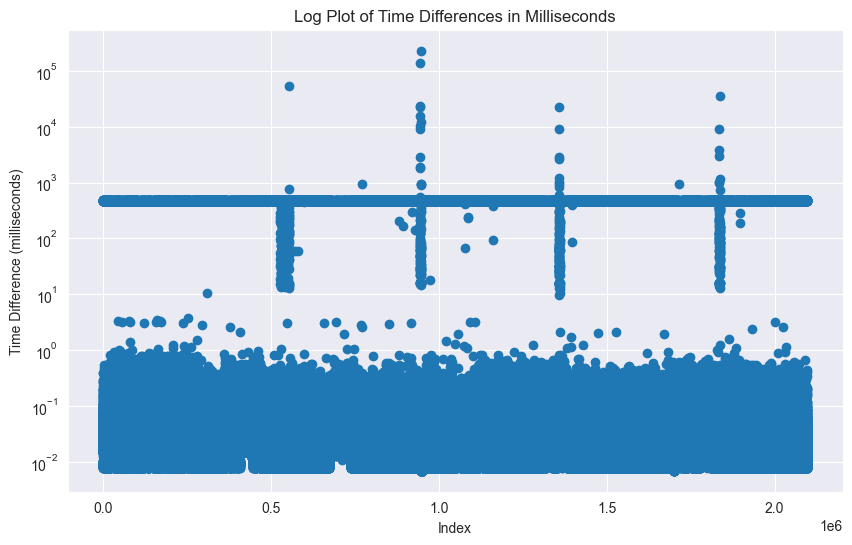

In [135]:
import matplotlib.pyplot as plt

# Get the non-NaT values from the 'time_diff' column
non_nat_time_diff = gaps_df['time_diff'].dropna()

# Convert the time differences to milliseconds
time_diff_millis = non_nat_time_diff.dt.total_seconds() * 1000

# Plot a log plot of the time differences in milliseconds
plt.figure(figsize=(10, 6))
plt.semilogy(time_diff_millis, marker='o', linestyle='None')
plt.xlabel('Index')
plt.ylabel('Time Difference (milliseconds)')
plt.title('Log Plot of Time Differences in Milliseconds')
plt.grid(True)
plt.show()

In [136]:
# Why 500ms?  Because there are very regular gaps of ~430ms.
def gap_fill(df):
    # Identify gaps greater than 500 ms
    gaps = df['datetime'].diff() > pd.Timedelta('500ms')
    
    print("Gaps: ", gaps.value_counts())
    
    # Create a list to hold new rows
    new_rows = []
    
    # Iterate over the DataFrame to find gaps and create new rows
    for i in range(1, len(df)):
        if gaps.iloc[i]:
            start_time = df['datetime'].iloc[i - 1]
            end_time = df['datetime'].iloc[i]
            print(f"Gap {i} start time: ", start_time)   
            print(f"Gap {i} end time: ", end_time)
            while start_time < end_time:
                start_time += pd.Timedelta((1 / 250), unit='s')
                new_row = {}
                for c in channels:
                    new_row[c] = 0
                new_row['datetime'] = start_time
                new_row['Inserted'] = 1
                new_row['sampleIdx'] = -999
                new_rows.append(new_row)
    
    # Append new rows to the original DataFrame
    new_rows_df = pd.DataFrame(new_rows)
    df['Inserted'] = 0
    copied = pd.concat([df, new_rows_df], ignore_index=True)
    
    # Sort the DataFrame by the 'datetime' column
    copied = copied.sort_values(by='datetime').reset_index(drop=True)
    
    # Fill NaN values with empty values
    copied.fillna('', inplace=True)
    
    return copied

filled = gap_fill(copied)
print(filled['Inserted'].value_counts())
print_stats(filled)

Gaps:  datetime
False    2097107
True          37
Name: count, dtype: int64
Gap 553403 start time:  2024-11-15 10:03:24.499017954+00:00
Gap 553403 end time:  2024-11-15 10:04:17.630275011+00:00
Gap 553808 start time:  2024-11-15 10:04:19.601316929+00:00
Gap 553808 end time:  2024-11-15 10:04:20.374664068+00:00
Gap 770247 start time:  2024-11-15 10:18:44.917668104+00:00
Gap 770247 end time:  2024-11-15 10:18:45.878401995+00:00
Gap 945022 start time:  2024-11-15 10:30:24.065485001+00:00
Gap 945022 end time:  2024-11-15 10:32:42.103118896+00:00
Gap 945294 start time:  2024-11-15 10:32:43.040092945+00:00
Gap 945294 end time:  2024-11-15 10:32:53.352596045+00:00
Gap 945302 start time:  2024-11-15 10:32:53.352953911+00:00
Gap 945302 end time:  2024-11-15 10:33:08.656553030+00:00
Gap 945309 start time:  2024-11-15 10:33:08.694536924+00:00
Gap 945309 end time:  2024-11-15 10:33:10.601130009+00:00
Gap 945489 start time:  2024-11-15 10:33:11.508986950+00:00
Gap 945489 end time:  2024-11-15 10:33

C:\Users\graha\AppData\Local\Temp\ipykernel_22476\732574791.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  copied.fillna('', inplace=True)


Inserted
0    2097144
1     156162
Name: count, dtype: int64
Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:30:13.224000
	Samples:  2253306
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  -1 days +23:59:52.451579071
	Samples:  -1887.1052500000224
Gaps:
	In sample index:  69
	In timestamps:  0


In [137]:
filled['Inserted'].value_counts()

Inserted
0    2097144
1     156162
Name: count, dtype: int64

In [138]:
print("Initial: ")
print_stats(idx_and_eeg_channels_and_timestamp)

print("\nAfter dropping rows: ")
print_stats(copied)

print("\nAfter filling gaps: ")
print_stats(filled)

Initial: 
Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:22:24.120000
	Samples:  2136030
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  0 days 00:07:41.555579071
	Samples:  115388.89474999998
Gaps:
	In sample index:  9739
	In timestamps:  89

After dropping rows: 
Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:19:48.576000
	Samples:  2097144
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  0 days 00:10:17.099579071
	Samples:  154274.89474999998
Gaps:
	In sample index:  0
	In timestamps:  37

After filling gaps: 
Actual:
	First:  2024-11-15 09:26:33.913368940+00:00
	Last:  2024-11-15 11:56:39.588948011+00:00
	Time:  2:30:13.224000
	Samples:  2253306
Expected:
	Time:  0 days 02:30:05.675579071
	Samples:  2251418.89475
Missing:
	Time:  -1 days +23:59:52.451579071
	Samples:  -1887.1052500000224
Ga

In [140]:
# Note some added sample index gaps on `filled` are normal, since we've inserted fake data.

In [154]:
from convert import convert_and_save_brainflow_file_with_gap_filling

convert_and_save_brainflow_file_with_gap_filling(log, input_file, "temp.fif", channels)

2024-11-16 15:49:33,691 - INFO - Memory Usage: 2275.83 MB GC to 2117.84 MB
2024-11-16 15:49:33,692 - INFO - Reading Brainflow file C:\dev\play\brainwave-data-day\2024-11-15-09-26-33.brainflow.csv
2024-11-16 15:50:09,332 - INFO - Finished reading Brainflow file
2024-11-16 15:50:09,497 - INFO - Memory Usage: 2508.96 MB GC to 2508.96 MB
2024-11-16 15:50:09,499 - INFO - EEG channels: [1, 2, 3, 4, 5, 6, 7, 8]
C:\dev\play\brainwave-processor\convert.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Processing rows: 100%|██████████| 2136030/2136030 [00:00<00:00, 2551543.79it/s]


Gaps:  datetime
False    2100066
True         150
Name: count, dtype: int64
Gap 553403 start time:  2024-11-15 10:03:24.499017954+00:00
Gap 553403 end time:  2024-11-15 10:03:35.754298925+00:00
Gap 553404 start time:  2024-11-15 10:03:35.754298925+00:00
Gap 553404 end time:  2024-11-15 10:04:08.522433043+00:00
Gap 553405 start time:  2024-11-15 10:04:08.522433043+00:00
Gap 553405 end time:  2024-11-15 10:04:17.630316973+00:00
Gap 553808 start time:  2024-11-15 10:04:19.601316929+00:00
Gap 553808 end time:  2024-11-15 10:04:20.374664068+00:00
Gap 770247 start time:  2024-11-15 10:18:44.917668104+00:00
Gap 770247 end time:  2024-11-15 10:18:45.878401995+00:00
Gap 945022 start time:  2024-11-15 10:30:24.065485001+00:00
Gap 945022 end time:  2024-11-15 10:30:28.038647890+00:00
Gap 945025 start time:  2024-11-15 10:30:28.038770914+00:00
Gap 945025 end time:  2024-11-15 10:30:32.402225018+00:00
Gap 945026 start time:  2024-11-15 10:30:32.402225018+00:00
Gap 945026 end time:  2024-11-15 10:30

C:\dev\play\brainwave-processor\convert.py:149: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  log(f"Reading Brainflow file {input_file}")
2024-11-16 15:50:20,946 - INFO - Initial timestamp: 2024-11-15 09:26:33.913368940+00:00 from 1731662793.913369


Creating RawArray with float64 data, n_channels=1, n_times=2252708
    Range : 0 ... 2252707 =      0.000 ...  9010.828 secs
Ready.


2024-11-16 15:50:20,950 - INFO - Info <Info | 7 non-empty values
 bads: []
 ch_names: Fpz-M1
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: 2024-11-15 09:26:33 UTC
 nchan: 1
 projs: []
 sfreq: 250.0 Hz
>
2024-11-16 15:50:21,137 - INFO - Memory Usage: 2722.72 MB GC to 2721.72 MB


FileNotFoundError: [WinError 3] The system cannot find the path specified: ''